In [2]:
%pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 2.0 MB/s eta 0:00:00


In [7]:
import osmnx as ox
import matplotlib.pyplot as plt
import networkx as nx

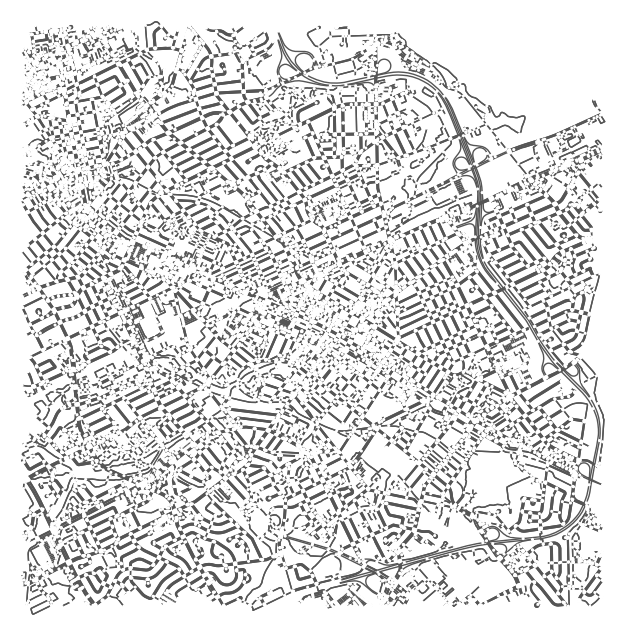

In [6]:
# 2. Define center coordinates for King & Victoria in Kitchener, ON
# Coordinates obtained via geocoding
center_point = (43.4516, -80.4925)  # (latitude, longitude)

# 3. Define search radius in meters
radius = 3000  # 4 km

# 4. Download street network within the specified radius
G = ox.graph_from_point(center_point, dist=radius, network_type='all')

# 5. Plot the map
fig, ax = ox.plot_graph(G, node_size=5, edge_color='#555555', bgcolor='white')

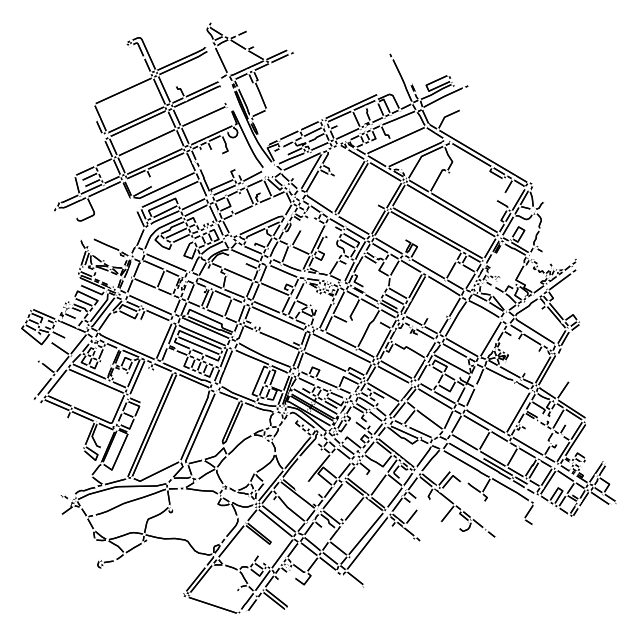

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [8]:
def get_graph_within_radius(center_point, search_radius=1000, download_radius=3000, network_type='walk'):
    """
    Returns a subgraph of all nodes and edges within `search_radius` meters
    of the `center_point`, based on shortest path distance.

    Parameters:
        center_point (tuple): (latitude, longitude)
        search_radius (int): Radius in meters for inclusion in subgraph (shortest-path based)
        download_radius (int): Radius in meters to download OSM graph
        network_type (str): 'walk', 'drive', 'bike', or 'all'

    Returns:
        networkx.MultiDiGraph: Subgraph of nodes/edges within shortest path distance
    """
    # Download a graph large enough to cover the search radius
    G = ox.graph_from_point(center_point, dist=download_radius, network_type=network_type)

    # Find the nearest node to the center point
    center_node = ox.distance.nearest_nodes(G, X=center_point[1], Y=center_point[0])

    # Use Dijkstra to find all nodes within search_radius (in meters)
    lengths = nx.single_source_dijkstra_path_length(G, center_node, cutoff=search_radius, weight='length')

    # Get the nodes within the radius
    nearby_nodes = set(lengths.keys())

    # Extract the subgraph
    subgraph = G.subgraph(nearby_nodes).copy()

    return subgraph



# Coordinates of King & Victoria, Kitchener, ON
center = (43.4516, -80.4925)

# Get subgraph within 1km shortest-path distance
G_sub = get_graph_within_radius(center_point=center, search_radius=1000)

# Plot the result
ox.plot_graph(G_sub, node_size=5, edge_color='black', bgcolor='white')

In [5]:
#ox.plot_graph(G_sub, node_size=5, edge_color='black', bgcolor='white')

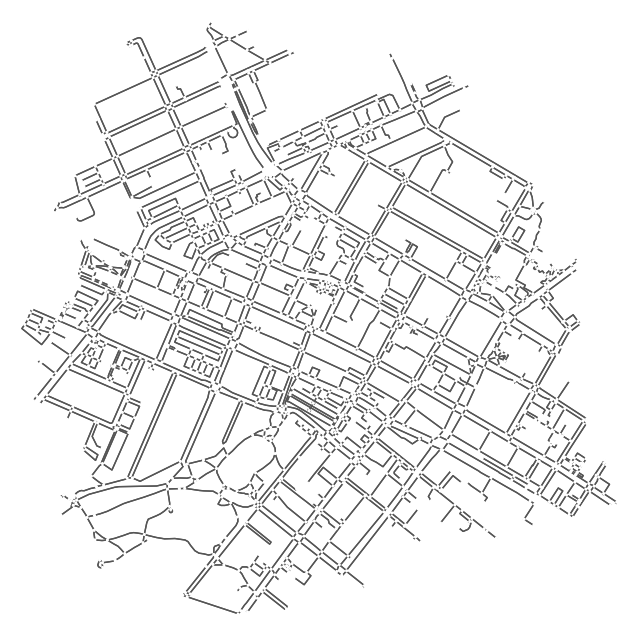

In [11]:
#fig, ax = ox.plot_graph(G_sub, node_size=5, edge_color='#555555', bgcolor='white')

Found 3 traffic lights.


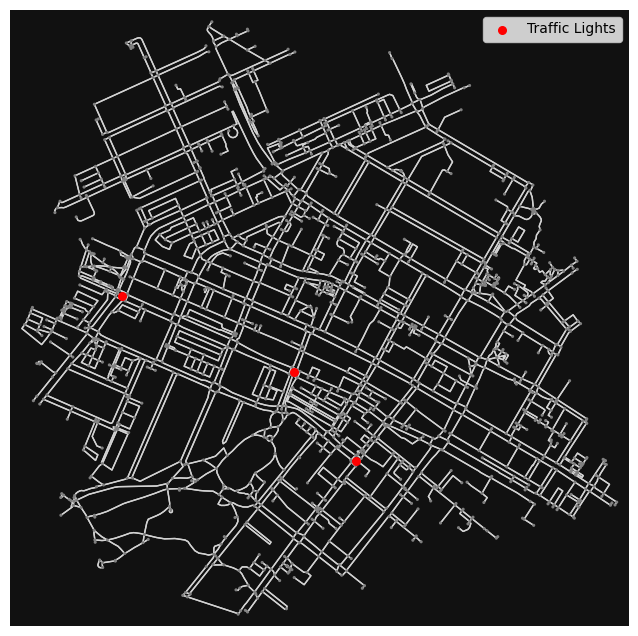

In [9]:
def get_traffic_lights(G):
    """
    Returns a list of node IDs that are traffic lights in the graph G.

    Parameters:
        G (networkx.MultiDiGraph): The OSMnx graph.

    Returns:
        list: Node IDs of traffic lights.
    """
    traffic_lights = [
        node for node, data in G.nodes(data=True)
        if data.get('highway') == 'traffic_signals'
    ]
    return traffic_lights

def plot_traffic_lights(ax, G, lights):
  # Extract coordinates for plotting
  x = [G.nodes[n]['x'] for n in lights]
  y = [G.nodes[n]['y'] for n in lights]

  # Plot traffic lights in red
  ax.scatter(x, y, c='red', s=30, label='Traffic Lights')
  ax.legend()

# Get traffic lights in the subgraph
lights = get_traffic_lights(G_sub)

print(f"Found {len(lights)} traffic lights.")

# Optional: Plot them on the graph
import matplotlib.pyplot as plt

fig, ax = ox.plot_graph(G_sub, node_size=5, node_color='gray', edge_color='lightgray', show=False, close=False)

plot_traffic_lights(ax, G_sub, lights)
"""
# Extract coordinates for plotting
x = [G_sub.nodes[n]['x'] for n in lights]
y = [G_sub.nodes[n]['y'] for n in lights]

# Plot traffic lights in red
ax.scatter(x, y, c='red', s=30, label='Traffic Lights')
ax.legend()
"""
plt.show()

In [3]:
import osmnx as ox
import networkx as nx

def get_graph_within_radius_with_penalty(center_point,
                                         search_radius=1000,
                                         download_radius=2000,
                                         network_type='walk',
                                         traffic_light_penalty=30):
    """
    Returns a subgraph of all nodes/edges within a search radius from a center point,
    applying a penalty to edges connected to traffic lights.

    Parameters:
        center_point (tuple): (latitude, longitude)
        search_radius (int): Distance in meters for inclusion in subgraph (Dijkstra-based)
        download_radius (int): Distance in meters for OSM download area
        network_type (str): 'walk', 'drive', 'bike', or 'all'
        traffic_light_penalty (float): Meters added to edge weight if connected to a traffic signal

    Returns:
        networkx.MultiDiGraph: Penalized subgraph
    """
    # Step 1: Download the graph
    G = ox.graph_from_point(center_point, dist=download_radius, network_type=network_type)

    # Step 2: Find all traffic light nodes
    traffic_lights = {
        node for node, data in G.nodes(data=True)
        if data.get('highway') == 'traffic_signals'
    }

    # Step 3: Assign custom weights to edges
    for u, v, key, data in G.edges(keys=True, data=True):
        base_length = data.get('length', 1)  # default fallback
        # Penalize if either node is a traffic light
        if u in traffic_lights or v in traffic_lights:
            data['penalized_length'] = base_length + traffic_light_penalty
        else:
            data['penalized_length'] = base_length

    # Step 4: Compute shortest path distances using penalized weights
    center_node = ox.distance.nearest_nodes(G, X=center_point[1], Y=center_point[0])
    lengths = nx.single_source_dijkstra_path_length(
        G, center_node, cutoff=search_radius, weight='penalized_length'
    )

    # Step 5: Build and return the subgraph
    nearby_nodes = set(lengths.keys())
    subgraph = G.subgraph(nearby_nodes).copy()
    return subgraph


Found 3 traffic lights.


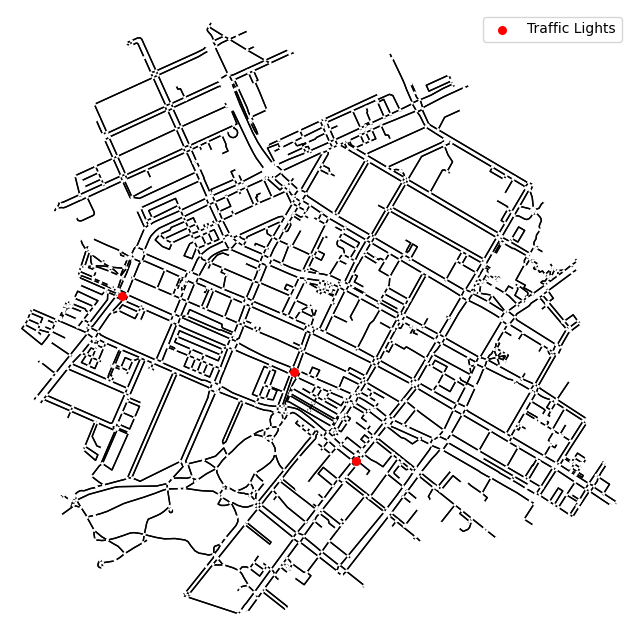

In [12]:
# Coordinates of King & Victoria
center = (43.4516, -80.4925)

# Get subgraph with traffic light penalties
G_penalized = get_graph_within_radius_with_penalty(center_point=center, traffic_light_penalty=30)

# Plot it
fig, ax = ox.plot_graph(G_penalized, node_size=5, edge_color='black', bgcolor='white', show=False, close=False)

lights = get_traffic_lights(G_penalized)
print(f"Found {len(lights)} traffic lights.")
plot_traffic_lights(ax, G_penalized, lights)

plt.show()